In [1]:
import tensorflow as tf
import pandas as pd
import xarray as xr
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error,confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
import keras
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier




# Deep learning model
from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate, Embedding, Dropout, Flatten
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from keras.regularizers import l1
from keras.layers import BatchNormalization
from scikeras.wrappers import KerasClassifier, KerasRegressor
import keras.backend as K


2024-05-09 18:54:41.145176: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-09 18:54:41.185527: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 18:54:41.185579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 18:54:41.186734: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-09 18:54:41.193103: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-09 18:54:41.193623: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [4]:
parameter_data = pd.read_csv('../02_machine_learning/parameter_data_lead_time_also_FZ.csv')
#parameter_data.drop(columns=['airport_id'], inplace=True)
#parameter_data['airport_id'] = pd.factorize(parameter_data['airport'])[0]

In [5]:
parameter_data = parameter_data[parameter_data['metartype'] != 'AUTO']

In [6]:
parameter_data = parameter_data.drop(columns=['airport_id'])
parameter_data['airport_id'] = pd.factorize(parameter_data['airport'])[0]

In [9]:
# Train test split
X_train, X_test = train_test_split(parameter_data, test_size = 0.2, random_state=9)

### Downsampling the occurrences of FALSE for contain_FZ

In [10]:
downsampling_percentage = 0.006

fz_majority = X_train[X_train['contain_FZ'] == False]
fz_minority = X_train[X_train['contain_FZ'] == True]

print(f'Size of minority: {fz_majority.shape}')
print(f'Size of minority: {fz_minority.shape}')

majority_size = int(len(fz_majority) * downsampling_percentage)

#  Downsample the majority class to match the minority class
downsampled_majority = resample(fz_majority, replace=False, n_samples=majority_size, random_state=42)
print(f'Size of downsampled majority: {downsampled_majority.shape}')

# Combine the downsampled majority class with the original minority class
downsampled_X_train = pd.concat([downsampled_majority, fz_minority])

Size of minority: (327904, 127)
Size of minority: (1642, 127)
Size of downsampled majority: (1967, 127)


In [11]:
X_train_downsampled = downsampled_X_train.drop(['contain_FZ'], axis=1)
y_train = downsampled_X_train['contain_FZ']
y_test = X_test['contain_FZ']
X_test = X_test.drop(['contain_FZ'], axis=1)

## F1-score 

In [12]:
def f1_score_calc(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Standardize features

In [13]:
data_params = ['air_temperature_0m', 'air_temperature_2m', 'relative_humidity_2m', 'x_wind_10m', 'y_wind_10m', 'fog_area_fraction', 'surface_air_pressure', 
               'air_pressure_at_sea_level', 'precipitation_amount_calculated',
              'air_temperature_pl_850', 'x_wind_pl_850', 'y_wind_pl_850', 'air_temperature_pl_925', 'x_wind_pl_925', 'y_wind_pl_925',
              'liquid_water_content_of_surface_snow']

In [14]:
scaler = StandardScaler()

X_train_downsampled[data_params] = scaler.fit_transform(X_train_downsampled[data_params])
X_test[data_params] = scaler.transform(X_test[data_params])

## Embedding layer for airport id

In [15]:
num_airports = len(parameter_data['airport_id'].unique())
print(f'Number of airports: {num_airports}')
input_aid = Input(shape=(1,))
output_dim = 20

embedding_layer = Embedding(input_dim=num_airports, output_dim=output_dim, name="embedding_airport")(input_aid)
flatten_airports = Flatten()(embedding_layer)

emb_cat = Reshape(target_shape=(output_dim,))(flatten_airports)

Number of airports: 50


## Model: ANN

In [16]:
l1_lambda = 0.002

param_features_dim = Input(shape=(16,))

# Concatenate embedded categorical airport feature with param features
concat = Concatenate()([emb_cat, param_features_dim])

dense_layer_1 = Dense(units=64, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda), activation='relu')(concat)
batch_norm_1 = BatchNormalization()(dense_layer_1)
#dropout_1 = Dropout(0.2)(batch_norm_1)

dense_layer_2 = Dense(units=64, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda),activation='relu')(batch_norm_1)
batch_norm_2 = BatchNormalization()(dense_layer_2)

dense_layer_3 = Dense(units=64, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda),activation='relu')(batch_norm_2)
batch_norm_3 = BatchNormalization()(dense_layer_3)


#dense_layer_4 = Dense(units=64, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda),activation='relu')(batch_norm_3)
#batch_norm_4 = BatchNormalization()(dense_layer_4)

#dense_layer_4 = Dense(units=32, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda),activation='relu')(dense_layer_3)

#batch_norm_2 = BatchNormalization()(dense_layer_3)

#dense_layer_3 = Dense(units=64, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda), activation='relu')(batch_norm_2)
#batch_norm_3 = BatchNormalization()(dense_layer_3)

#dense_layer_4 = Dense(units=32, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda), activation='relu')(batch_norm_3)
#batch_norm_4 = BatchNormalization()(dense_layer_4)

# Output Layer
output_layer = Dense(units=1, activation='sigmoid')(batch_norm_3)
model = Model(inputs=[input_aid, param_features_dim], outputs=output_layer)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_airport (Embeddi  (None, 1, 20)                1000      ['input_1[0][0]']             
 ng)                                                                                              
                                                                                                  
 flatten (Flatten)           (None, 20)                   0         ['embedding_airport[0][0]']   
                                                                                                  
 reshape (Reshape)           (None, 20)                   0         ['flatten[0][0]']         

In [18]:
# Compile the model
ml_optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=ml_optimizer, metrics=[f1_score_calc])

In [19]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [20]:
history = model.fit([X_train_downsampled['airport_id'], X_train_downsampled[data_params]], y_train, epochs=100, batch_size=32, shuffle=True, validation_split=0.2, verbose=1, callbacks=early_stopping)

Epoch 1/100


/home/tonjek/.local/lib/python3.9/site-packages/keras/src/engine/data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


91/91 [==============================] - 2s 4ms/step - loss: 3.6778 - f1_score_calc: 0.6359 - val_loss: 3.7917 - val_f1_score_calc: 0.5233
Epoch 2/100
91/91 [==============================] - 0s 2ms/step - loss: 3.0775 - f1_score_calc: 0.7161 - val_loss: 3.3474 - val_f1_score_calc: 0.6219
Epoch 3/100
91/91 [==============================] - 0s 2ms/step - loss: 2.6357 - f1_score_calc: 0.7415 - val_loss: 2.8943 - val_f1_score_calc: 0.7203
Epoch 4/100
91/91 [==============================] - 0s 2ms/step - loss: 2.2920 - f1_score_calc: 0.7679 - val_loss: 2.5341 - val_f1_score_calc: 0.7473
Epoch 5/100
91/91 [==============================] - 0s 2ms/step - loss: 2.0287 - f1_score_calc: 0.7743 - val_loss: 2.2936 - val_f1_score_calc: 0.7693
Epoch 6/100
91/91 [==============================] - 0s 2ms/step - loss: 1.8158 - f1_score_calc: 0.7802 - val_loss: 2.1476 - val_f1_score_calc: 0.7655
Epoch 7/100
91/91 [==============================] - 0s 2ms/step - loss: 1.6490 - f1_score_calc: 0.8047 - 

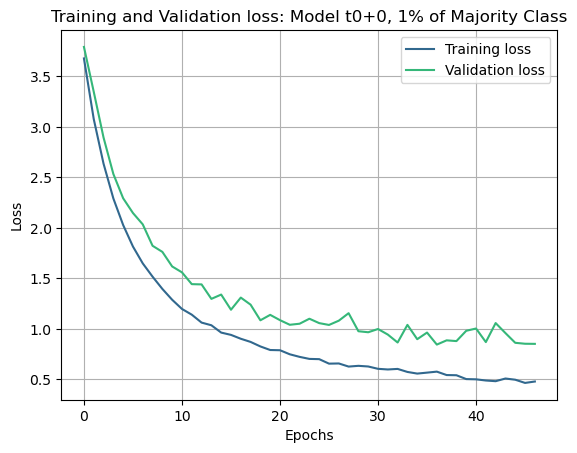

In [21]:
history = pd.DataFrame(history.history)

cmap_loss_val = sns.color_palette('viridis', 2)



plt.plot(history.loc[:, ['loss']], color=cmap_loss_val[0], label='Training loss')
plt.plot(history.loc[:, ['val_loss']], color=cmap_loss_val[1], label='Validation loss')
plt.title('Training and Validation loss: Model t0+0, 1% of Majority Class')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc="best")

#plt.savefig('training_validation_loss_t0+0.png')
plt.show()

## Prediction

In [22]:
# Make predictions
y_pred = model.predict([X_test['airport_id'], X_test[data_params]])

2575/2575 [==============================] - 2s 605us/step


In [23]:
y_pred_val = (y_pred > 0.4)
print(classification_report(y_test, y_pred_val))

              precision    recall  f1-score   support

       False       1.00      0.87      0.93     81987
        True       0.03      0.82      0.06       400

    accuracy                           0.87     82387
   macro avg       0.51      0.85      0.49     82387
weighted avg       0.99      0.87      0.93     82387



In [24]:
conf_matrix = confusion_matrix(y_test, y_pred_val)

In [25]:
conf_matrix

array([[71260, 10727],
       [   71,   329]])

In [26]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred_val)

In [27]:
f1

0.057437150837988823

## ROC AUC

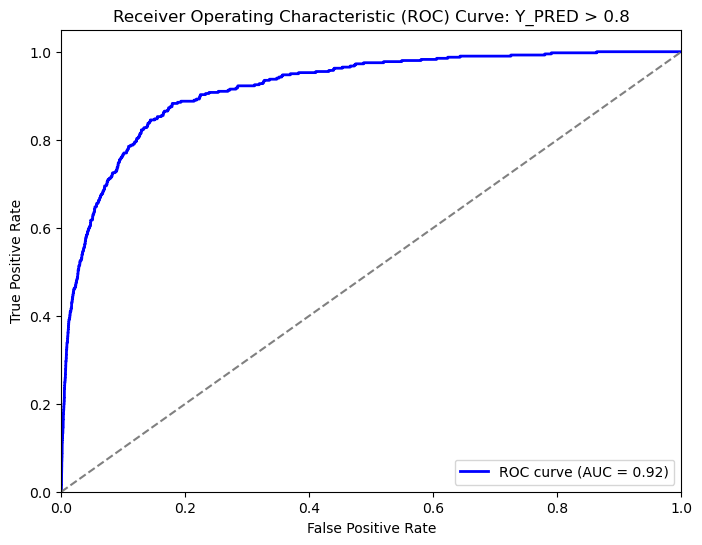

In [28]:

# Calculate fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve: Y_PRED > 0.8')
plt.legend(loc="lower right")
#plt.savefig('rocauc_instantaneous_0.8.png')
plt.show()

In [1]:
# Save y_pred as numpy
#np.save('y_pred_instant_without_auto.npy', y_pred)

# Save corresponding y_test
#np.save('y_test_instant_without_auto.npy', y_test)

# Analyzation of data
The code from here and forward is for analyzation purposes. 

In [37]:
y_pred = y_pred.flatten()

In [38]:
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Time': X_test['time'], 'Metar': X_test['metar']})

In [39]:
comparison_df.to_csv('comparison.csv', index=False)

In [40]:
pd.set_option('display.max_colwidth', 3000)

In [41]:
comparison_df[comparison_df['Predicted'] > 0.95].head(50)

,Actual,Predicted,Time,Metar
326069,True,0.987683,2022-11-19 14:00:00,ENNM 191350Z 10010KT 070V130 9999 NCD M00/M10 Q1024 REFZRA=
201927,False,0.960360,2022-04-26 13:00:00,ENHF 261320Z VRB06G23KT 9999 VCSH DRSN FEW016 BKN036 M07/M12 Q1013 RMK WIND 1254FT 32039G50KT=
384220,False,0.985071,2021-11-17 15:00:00,ENRO 171450Z 23006KT 200V260 CAVOK 02/M03 Q0998=
380564,False,0.986266,2021-01-25 04:00:00,ENRO 250420Z 22003KT 8000NDV BKN004/// OVC005/// M12/M14 Q0997=
431284,True,0.990260,2023-12-21 00:00:00,ENSG 210020Z 00000KT 0200 R24/0450 FZFG VV002 M03/M03 Q0981 RMK WIND 3806FT 21022KT=
14614,False,0.970991,2022-01-17 10:00:00,ENAN 170950Z 34022G34KT 9999 DRSN FEW030 SCT037 BKN055 M01/M05 Q0998=
395991,False,0.973425,2021-01-24 18:00:00,ENRS 241750Z 17014KT 4000 -SN VV004 M01/M03 Q0993=
243325,False,0.993363,2023-03-07 22:00:00,ENKB 072150Z 05008KT 2000 SN VV005 M04/M05 Q0990 RMK WIND 745FT 06011G22KT=
174138,False,0.994929,2021-02-02 05:00:00,ENGM 020450Z 02004KT 9999 OVC034 M11/M13 Q1003 NOSIG=
173351,False,0.962265,2021-02-22 10:00:00,ENGK 220950Z 01004KT 340V040 0600 FG VV001 03/03 Q1016=


In [186]:
comparison_df[comparison_df['Actual'] == True].head(50)

,Actual,Predicted,Time,Metar
505912,True,0.978720,2023-01-06 18:00:00,ENTO 061820Z 03006KT 3200 -SN OVC002 M02/M02 Q1005 TEMPO 4000 -FZDZ=
326069,True,0.980900,2022-11-19 14:00:00,ENNM 191350Z 10010KT 070V130 9999 NCD M00/M10 Q1024 REFZRA=
501905,True,0.858779,2021-12-09 02:00:00,ENTO 090220Z 10005KT 080V130 2600 -FZDZ OVC004/// M01/M01 Q1010 REFZDZ=
431284,True,0.896447,2023-12-21 00:00:00,ENSG 210020Z 00000KT 0200 R24/0450 FZFG VV002 M03/M03 Q0981 RMK WIND 3806FT 21022KT=
145976,True,0.930844,2023-02-02 06:00:00,ENDU 020620Z 00000KT 2500 1000E R10/1200U R28/1200D PRFG BR SCT002 BKN004 M15/M16 Q1009 TEMPO 0700 FZFG VV002 RMK WIND 1100FT VRB01KT WIND 2200FT 34005KT=
500276,True,0.895710,2021-03-10 03:00:00,ENTO 100320Z 10007KT 050V140 9999 FZUP OVC020/// M01/M05 Q1019=
494560,True,0.046970,2023-02-28 19:00:00,ENTC 281920Z 26004KT 5000 -SHSN BKN004 M01/M01 Q1016 TEMPO 3000 -FZDZ SCT003 BKN020 RMK WIND 2600FT 24010KT=
411096,True,0.257747,2023-02-07 03:00:00,ENRY 070320Z VRB01KT 0350NDV R12/1500U R30/1200V1900D FZFG FEW000/// BKN190/// M03/M03 Q1033=
174069,True,0.993087,2021-01-30 08:00:00,ENGM 300750Z 00000KT 1000 0450NE R19R/P2000N R01R/P2000N R19L/0600D R01L/1200D FZFG VV002 M15/M16 Q0999 NOSIG=
125831,True,0.346773,2021-02-17 14:00:00,ENCN 171350Z 04011KT 9999 -FZDZ BKN010 M01/M03 Q1013=


<AxesSubplot: >

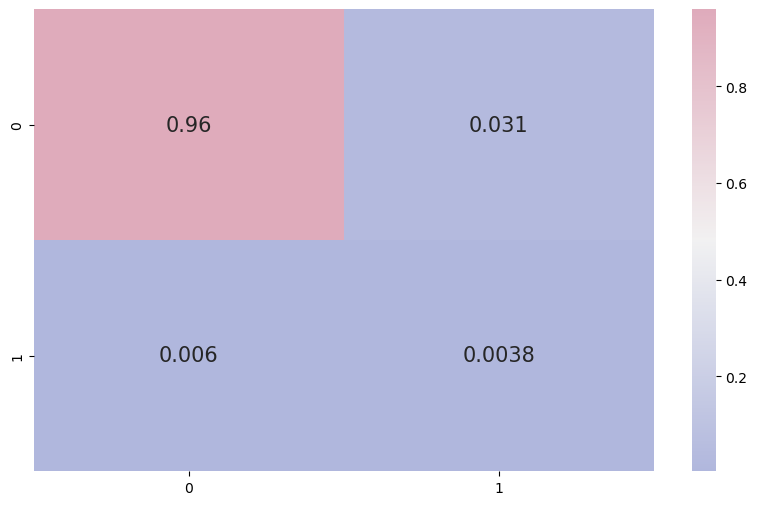

In [30]:
# confusion matrix
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(10,6))
cf_matrix = confusion_matrix(y_test, y_pred_val)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

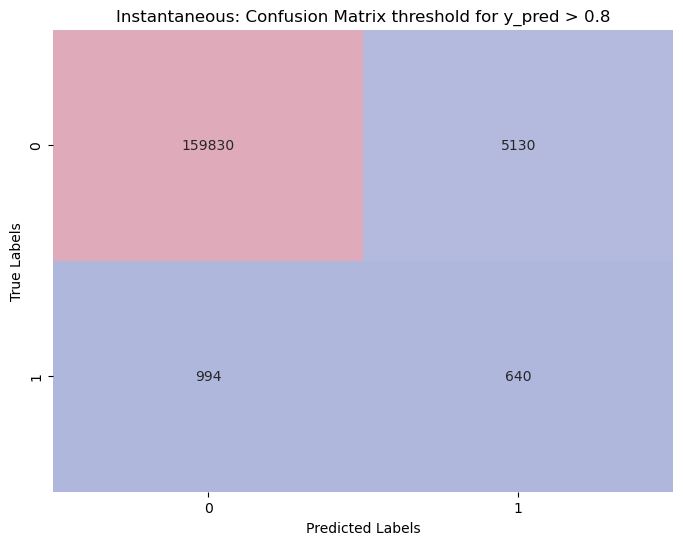

In [31]:
conf_matrix = confusion_matrix(y_test, y_pred_val)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=cmap1, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Instantaneous: Confusion Matrix threshold for y_pred > 0.8')
plt.savefig('cmap_instantaneous_0.8.png')
plt.show()